In [1]:
import datetime
import os
import time

import numpy as np
import torch
import torch.utils.data
from torch import nn
import torchvision
from torchvision.transforms import functional as F
from PIL import Image

import argparse


In [2]:
parser = argparse.ArgumentParser(description='PyTorch Segmentation Inference', add_help=True)

parser.add_argument('--model', default='fcn_resnet101', help='model')
parser.add_argument('--model-path', default='checkpoint.pth', help='path to the model checkpoint')
parser.add_argument('--device', default='cpu', help='device')
parser.add_argument('-i', '--input', default='test.jpg', help='file to infere')
parser.add_argument('-o', '--output', default='inference.png', help='output file')

_StoreAction(option_strings=['-o', '--output'], dest='output', nargs=None, const=None, default='inference.png', type=None, choices=None, help='output file', metavar=None)

In [14]:
print('Available models:')
print('\n'.join(list(torchvision.models.segmentation.__dict__)[14:20]))

Available models:
fcn_resnet50
fcn_resnet101
deeplabv3_resnet50
deeplabv3_resnet101
deeplabv3_mobilenet_v3_large
lraspp_mobilenet_v3_large


In [67]:
class Args:
    def __init__(self) -> None:
        self.model = 'fcn_resnet101'
        self.model_path = 'ResNet101-30epochs/checkpoint.pth'
        #self.model =      'deeplabv3_resnet101'
        #self.model_path = 'Deeplabv3_Resnet10-30epochs/checkpoint.pth'
        #self.model =      'lraspp_mobilenet_v3_large'
        #self.model_path = 'MobileNetV3-50epoch/checkpoint.pth'
        
        self.device = 'cpu'
        self.file = '200.jpg'
        self.output = 'inference.png'
args = Args()

In [126]:

def load_model(path, model_type, device):
    model = torchvision.models.segmentation.__dict__[model_type](
        num_classes=3
    )
    model.to(device)
    checkpoint = torch.load(path, map_location='cpu')
    model.load_state_dict(checkpoint['model'], strict=False)
    model.eval()
    return model

In [100]:
def inference(model, image_path):
    image_original = Image.open(image_path).convert('RGB')
    image = F.resize(image_original, 100, interpolation=F.InterpolationMode.NEAREST)
    image = F.to_tensor(image)[None,:,:,:]
    image = F.normalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    with torch.no_grad():
        output = model(image)
        output = torch.nn.functional.softmax(output['out'], 1)[0,:,:,:]
    return image_original, output

In [144]:
def plot_results(image_original, output, number_of_rows=1, row=1):
    import matplotlib.pyplot as plt

    ax1 = plt.subplot(number_of_rows,3,(row-1)*3+1)
    ax1.margins(0.05)
    ax1.imshow(image_original)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    ax2 = plt.subplot(number_of_rows,3,(row-1)*3+2)
    ax2.margins(2, 2)
    ax2.imshow(output[0])
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax3 = plt.subplot(number_of_rows,3,(row-1)*3+3)
    ax3.margins(2, 2)
    ax3.imshow(np.array(output[1]))
    ax3.axes.get_xaxis().set_visible(False)
    ax3.axes.get_yaxis().set_visible(False)
    if row == 1:
        ax1.title.set_text("Vstup")
        ax2.title.set_text("Optický disk")
        ax3.title.set_text("Makula")

In [153]:
def evaluate(model_path, model_type):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4, 4), dpi=80)
    model = load_model(model_path, model_type, "cpu")
    plot_results(*inference(model, "images/1.jpg")   ,3,1)
    plot_results(*inference(model, "images/82.jpg")  ,3,2)
    plot_results(*inference(model, "images/200.jpg") ,3,3)
    plt.savefig(f"eval_{model_type}.png", pad_inches=(0,0))

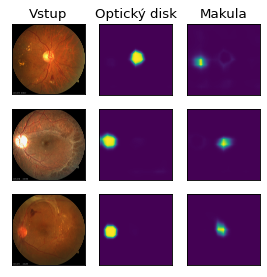

In [154]:
evaluate('Deeplabv3_Resnet10-30epochs/checkpoint.pth', 'deeplabv3_resnet101')

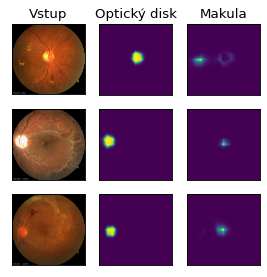

In [155]:
evaluate('ResNet101-30epochs/checkpoint.pth', 'fcn_resnet101')

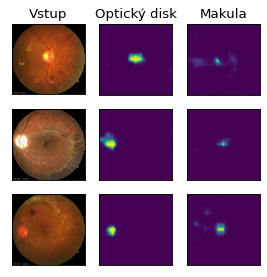

In [156]:
evaluate('MobileNetV3-50epoch/checkpoint.pth', 'lraspp_mobilenet_v3_large')